In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import BSE
import os

plt.rcParams["figure.figsize"] = (8,5)
plt.rcParams["axes.grid"] = True

In [2]:
df_ibm = pd.read_csv("../Data/offset-ibm-1m-170831.csv")
price_col = df_ibm.select_dtypes(include=[np.number]).columns[-1]
ibm_prices = df_ibm[price_col].values
print("✔ IBM loaded. Using price column:", price_col)

✔ IBM loaded. Using price column: 3958


In [3]:
def make_SD_from_prices(prices, duration=40):
    mid = np.mean(prices)
    bid = mid - 2
    ask = mid + 2

    return {
        "sup": [{"from":0, "to":duration, "ranges":[(ask,25)], "stepmode":"fixed"}],
        "dem": [{"from":0, "to":duration, "ranges":[(bid,25)], "stepmode":"fixed"}],
        "interval": 1,
        "timemode": "periodic"
    }

sd_ibm = make_SD_from_prices(ibm_prices)

In [4]:
sd_syn = {
    "sup":[{"from":0,"to":40,"ranges":[(200,25)],"stepmode":"fixed"}],
    "dem":[{"from":0,"to":40,"ranges":[(180,25)],"stepmode":"fixed"}],
    "interval":1,
    "timemode":"periodic"
}

In [5]:
def extract_trade_price(df):
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    if len(numeric_cols) == 0:
        return None

    return numeric_cols[0]   

In [6]:
def run_market(session, sd, bid_percent, duration=40):

    trader_spec = {
        "buyers":[("ZIP",10)],
        "sellers":[("ZIP",10)],
        "mrktmakers":[
            ("MMM01",1,{
                "n_past_trades":5,
                "bid_percent":bid_percent,
                "ask_delta":25
            })
        ]
    }

    dump_flags = {
        "dump_strats":False,
        "dump_lobs":False,
        "dump_tape":True,
        "dump_blotters":False,
        "dump_avgbals":False
    }

    BSE.market_session(
        session,      
        0,            
        duration,     
        trader_spec,  
        sd,           
        dump_flags,   
        False         
    )

    filename = f"{session}_tape.csv"
    if not os.path.exists(filename):
        return 0

    df = pd.read_csv(filename)
    if df.empty:
        return 0

    price_column = extract_trade_price(df)
    if price_column is None:
        return 0

    return df[price_column].mean()

In [7]:
bid_list = [0.90, 0.95, 0.98]
N_IID = 5

def evaluate(sd):
    out = []
    for bp in bid_list:
        profits = []
        for r in range(N_IID):
            sess = f"Q3_bp{bp}_r{r}"
            p = run_market(sess, sd, bp, duration=40)
            profits.append(p)

        out.append({"bid_percent":bp, "mean_profit":np.mean(profits)})

    return pd.DataFrame(out)

df_syn = evaluate(sd_syn)
df_ibm = evaluate(sd_ibm)

print("Synthetic:\n", df_syn)
print("\nIBM:\n", df_ibm)

MM01 init: n_past_trades=5, bid_percent=0.90000, ask_delta=25

MM01 init: n_past_trades=5, bid_percent=0.90000, ask_delta=25

MM01 init: n_past_trades=5, bid_percent=0.90000, ask_delta=25

MM01 init: n_past_trades=5, bid_percent=0.90000, ask_delta=25

MM01 init: n_past_trades=5, bid_percent=0.90000, ask_delta=25

MM01 init: n_past_trades=5, bid_percent=0.95000, ask_delta=25

MM01 init: n_past_trades=5, bid_percent=0.95000, ask_delta=25

MM01 init: n_past_trades=5, bid_percent=0.95000, ask_delta=25

MM01 init: n_past_trades=5, bid_percent=0.95000, ask_delta=25

MM01 init: n_past_trades=5, bid_percent=0.95000, ask_delta=25

MM01 init: n_past_trades=5, bid_percent=0.98000, ask_delta=25

MM01 init: n_past_trades=5, bid_percent=0.98000, ask_delta=25

MM01 init: n_past_trades=5, bid_percent=0.98000, ask_delta=25

MM01 init: n_past_trades=5, bid_percent=0.98000, ask_delta=25

MM01 init: n_past_trades=5, bid_percent=0.98000, ask_delta=25

MM01 init: n_past_trades=5, bid_percent=0.90000, ask_de

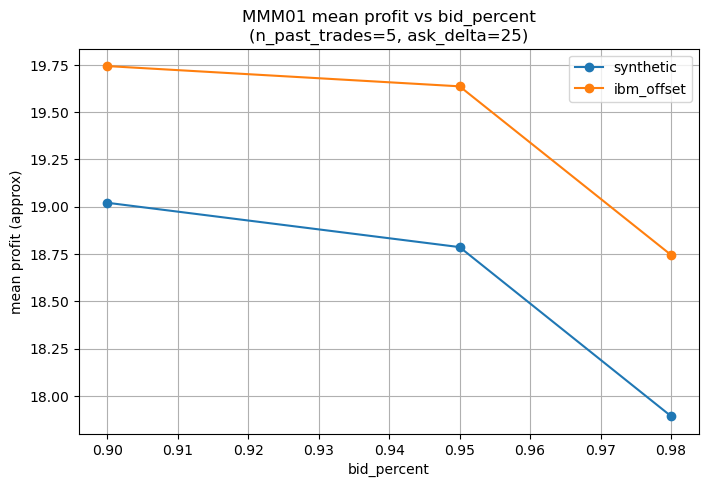

In [8]:
plt.plot(df_syn["bid_percent"], df_syn["mean_profit"], marker="o", label="synthetic")
plt.plot(df_ibm["bid_percent"], df_ibm["mean_profit"], marker="o", label="ibm_offset")

plt.title("MMM01 mean profit vs bid_percent\n(n_past_trades=5, ask_delta=25)")
plt.xlabel("bid_percent")
plt.ylabel("mean profit (approx)")
plt.legend()
plt.show()